In [1]:
from optstoicpy.core.drawpathway import draw_pathway
from optstoicpy.core.pathway import Pathway
from optstoicpy.core.database import Database
from optstoicpy.core.database import load_db_v3_ecolicore
from optstoicpy.core.database import load_base_reaction_db_ecolicore
from optstoicpy.core.database import load_db_v3
from optstoicpy.core.database import load_base_reaction_db
from optstoicpy.script.database_preprocessing import blocked_reactions_analysis
from optstoicpy.script.database_preprocessing import test_internal_loop_analysis
from optstoicpy.script import optstoic
from optstoicpy.script.solver import load_pulp_solver
import pandas as pd
from IPython.display import display, Image

# optStoic (universal db)

Ejemplo con la base de datos que generaron los autores de `optStoic`

### inicializar base de datos y setear compuestos de entrada salida (glucosa -> acetyl CoA)

- `user_defined_export_rxns_Sji`: los metabolitos de la reacción global con su ID de kegg, van todos con coeficiente -1.0

- `specific_bounds`: dict con cada compuesto de la reacción general y sus lower y upper bound, aquí se especifica cuales se consumen (signo -) y cuales se producen (signo +)

- `custom_flux_constraints`: restricciones extra que regulan a los transportadores de electrones, basta con dejar límites abiertos 

- `pulp_solver`: lista con los posibles solvers a utilizar, optstoic toma el que esté disponible, pero con gurobi en general funciona más rápido

- `db3`: base de datos cargada y actualizada (`load_d_v3(user_defined_...)`), viene con las exchanges incorporadas

In [2]:
user_defined_export_rxns_Sji = {
    'EX_glc': {'C00031': -1.0},
    'EX_acetylCoA': {'C00024': -1.0},
    'EX_co2': {'C00011': -1.0},
    'EX_CoA': {'C00010': -1.0},
    'EX_nad': {'C00003': -1.0},
    'EX_adp': {'C00008': -1.0},
    'EX_phosphate': {'C00009': -1.0},
    'EX_pyruvate': {'C00022': -1.0},
    'EX_nadh': {'C00004': -1.0},
    'EX_atp': {'C00002': -1.0},
    'EX_h2o': {'C00001': -1.0},
    'EX_hplus': {'C00080': -1.0},
    'EX_nadp': {'C00006': -1.0},
    'EX_nadph': {'C00005': -1.0}
    }

specific_bounds = { 'EX_glc': {'LB': -1, 'UB': -1},
                'EX_acetylCoA': {'LB': 1, 'UB': 1},
                'EX_pyruvate': {'LB': 1, 'UB': 1},
                'EX_co2': {'LB': 1, 'UB': 1},
                'EX_CoA': {'LB': -1, 'UB': -1},
                'EX_nad': {'LB': -3, 'UB': 0},
                'EX_nadh': {'LB': 0, 'UB': 3},
                'EX_nadp': {'LB': -2, 'UB': 0},
                'EX_nadph': {'LB': 0, 'UB': 2},
                'EX_adp': {'LB': -1, 'UB': -1},
                'EX_phosphate': {'LB': -1, 'UB': -1},
                'EX_atp': {'LB': 1, 'UB': 1},
                'EX_h2o': {'LB': 1, 'UB': 1},
                'EX_hplus': {'LB': -11, 'UB': 11}}

custom_flux_constraints = [
        {'constraint_name': 'nadphcons1',
         'reactions': ['EX_nadph', 'EX_nadh'],
         'UB': 200,
         'LB': -200},
        {'constraint_name': 'nadphcons2',
        'reactions': ['EX_nadp', 'EX_nad'],
        'UB': 200,
        'LB': -200},
        {'constraint_name': 'nadphcons3',
        'reactions': ['EX_nadh', 'EX_nad'],
        'UB': 100,
        'LB': -100},
        {'constraint_name': 'nadphcons4',
        'reactions': ['EX_nadph', 'EX_nadp'],
        'UB': 100,
        'LB': -100}]

pulp_solver = load_pulp_solver(
        solver_names=[
            'SCIP_CMD',
            'GUROBI',
            'GUROBI_CMD',
            'CPLEX_CMD',
            'GLPK_CMD'])

db3 = load_db_v3(user_defined_export_rxns_Sji)

2021-03-16 13:13:52 optstoic.load_pulp_solver WARNING  Pulp solver set to GUROBI_CMD.
2021-03-16 13:13:52 optstoicpy.core.database.load_db_v3 DEBUG    Reading blocked reactions file...
2021-03-16 13:13:52 core.Database DEBUG    Reading S matrix from JSON...
2021-03-16 13:13:58 core.Database DEBUG    Reading reaction type file...
2021-03-16 13:13:58 core.Database DEBUG    Reading Nint(loop, j) from JSON...
2021-03-16 13:13:58 core.Database INFO     Validating database
2021-03-16 13:13:58 core.Database WARNING  Removing blocked reactions to reduce model size!
2021-03-16 13:13:58 core.Database DEBUG    Reaction R08505 removed from the database.
2021-03-16 13:13:58 core.Database DEBUG    Reaction R07882 removed from the database.
2021-03-16 13:13:58 core.Database DEBUG    Reaction R07885 removed from the database.
2021-03-16 13:13:58 core.Database DEBUG    Reaction R08859 removed from the database.
2021-03-16 13:13:58 core.Database DEBUG    Reaction R01000 removed from the database.
2021-0

2021-03-16 13:13:58 core.Database DEBUG    Reaction R02587 removed from the database.
2021-03-16 13:13:58 core.Database DEBUG    Reaction R00723 removed from the database.
2021-03-16 13:13:58 core.Database DEBUG    Reaction R10351 removed from the database.
2021-03-16 13:13:58 core.Database DEBUG    Reaction R05443 removed from the database.
2021-03-16 13:13:58 core.Database DEBUG    Reaction R08319 removed from the database.
2021-03-16 13:13:58 core.Database DEBUG    Reaction R05447 removed from the database.
2021-03-16 13:13:58 core.Database DEBUG    Reaction R00129 removed from the database.
2021-03-16 13:13:58 core.Database DEBUG    Reaction R05448 removed from the database.
2021-03-16 13:13:58 core.Database DEBUG    Reaction R04758 removed from the database.
2021-03-16 13:13:58 core.Database DEBUG    Reaction R04756 removed from the database.
2021-03-16 13:13:58 core.Database DEBUG    Reaction R09252 removed from the database.
2021-03-16 13:13:58 core.Database DEBUG    Reaction R0

2021-03-16 13:13:58 core.Database DEBUG    Reaction R03577 removed from the database.
2021-03-16 13:13:58 core.Database DEBUG    Reaction R03576 removed from the database.
2021-03-16 13:13:58 core.Database DEBUG    Reaction R08080 removed from the database.
2021-03-16 13:13:58 core.Database DEBUG    Reaction R08081 removed from the database.
2021-03-16 13:13:58 core.Database DEBUG    Reaction R08082 removed from the database.
2021-03-16 13:13:58 core.Database DEBUG    Reaction R08083 removed from the database.
2021-03-16 13:13:58 core.Database DEBUG    Reaction R07509 removed from the database.
2021-03-16 13:13:58 core.Database DEBUG    Reaction R07058 removed from the database.
2021-03-16 13:13:58 core.Database DEBUG    Reaction R08087 removed from the database.
2021-03-16 13:13:58 core.Database DEBUG    Reaction R08088 removed from the database.
2021-03-16 13:13:58 core.Database DEBUG    Reaction R07057 removed from the database.
2021-03-16 13:13:58 core.Database DEBUG    Reaction R0

2021-03-16 13:13:58 core.Database DEBUG    Reaction R03329 removed from the database.
2021-03-16 13:13:58 core.Database DEBUG    Reaction R09908 removed from the database.
2021-03-16 13:13:58 core.Database DEBUG    Reaction R07264 removed from the database.
2021-03-16 13:13:58 core.Database DEBUG    Reaction R07267 removed from the database.
2021-03-16 13:13:58 core.Database DEBUG    Reaction R07260 removed from the database.
2021-03-16 13:13:58 core.Database DEBUG    Reaction R07263 removed from the database.
2021-03-16 13:13:58 core.Database DEBUG    Reaction R07262 removed from the database.
2021-03-16 13:13:58 core.Database DEBUG    Reaction R07269 removed from the database.
2021-03-16 13:13:58 core.Database DEBUG    Reaction R07268 removed from the database.
2021-03-16 13:13:58 core.Database DEBUG    Reaction R01732 removed from the database.
2021-03-16 13:13:58 core.Database DEBUG    Reaction R03395 removed from the database.
2021-03-16 13:13:58 core.Database DEBUG    Reaction R0

2021-03-16 13:13:58 core.Database DEBUG    Reaction R03231 removed from the database.
2021-03-16 13:13:58 core.Database DEBUG    Reaction R09630 removed from the database.
2021-03-16 13:13:58 core.Database DEBUG    Reaction R09632 removed from the database.
2021-03-16 13:13:58 core.Database DEBUG    Reaction R04868 removed from the database.
2021-03-16 13:13:58 core.Database DEBUG    Reaction R04714 removed from the database.
2021-03-16 13:13:58 core.Database DEBUG    Reaction R04715 removed from the database.
2021-03-16 13:13:58 core.Database DEBUG    Reaction R04716 removed from the database.
2021-03-16 13:13:58 core.Database DEBUG    Reaction R09633 removed from the database.
2021-03-16 13:13:58 core.Database DEBUG    Reaction R04711 removed from the database.
2021-03-16 13:13:58 core.Database DEBUG    Reaction R04713 removed from the database.
2021-03-16 13:13:58 core.Database DEBUG    Reaction R01562 removed from the database.
2021-03-16 13:13:58 core.Database DEBUG    Reaction R1

2021-03-16 13:13:58 core.Database DEBUG    Reaction R03827 removed from the database.
2021-03-16 13:13:58 core.Database DEBUG    Reaction R03823 removed from the database.
2021-03-16 13:13:58 core.Database DEBUG    Reaction R03820 removed from the database.
2021-03-16 13:13:58 core.Database DEBUG    Reaction R02994 removed from the database.
2021-03-16 13:13:58 core.Database DEBUG    Reaction R02995 removed from the database.
2021-03-16 13:13:58 core.Database DEBUG    Reaction R02998 removed from the database.
2021-03-16 13:13:58 core.Database DEBUG    Reaction R02999 removed from the database.
2021-03-16 13:13:58 core.Database DEBUG    Reaction R10858 removed from the database.
2021-03-16 13:13:58 core.Database DEBUG    Reaction R02132 removed from the database.
2021-03-16 13:13:58 core.Database DEBUG    Reaction R02666 removed from the database.
2021-03-16 13:13:58 core.Database DEBUG    Reaction R02667 removed from the database.
2021-03-16 13:13:58 core.Database DEBUG    Reaction R0

2021-03-16 13:13:59 core.Database DEBUG    Reaction R05855 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R05856 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R05857 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R05858 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R00827 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R05676 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R05677 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R05672 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R05673 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R09771 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R09770 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R0

2021-03-16 13:13:59 core.Database DEBUG    Reaction R00048 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R09074 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R10606 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R10605 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R10609 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R10608 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R05335 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R05442 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R05441 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R05331 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R05330 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R0

2021-03-16 13:13:59 core.Database DEBUG    Reaction R08002 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R08003 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R08005 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R08006 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R08007 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R04247 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R07416 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R06366 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R03782 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R03780 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R03781 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R0

2021-03-16 13:13:59 core.Database DEBUG    Reaction R03881 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R03880 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R05766 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R05764 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R05765 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R05762 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R05763 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R05760 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R05761 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R05769 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R10346 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R1

2021-03-16 13:13:59 core.Database DEBUG    Reaction R06449 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R06119 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R02356 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R02354 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R02355 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R02358 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R02359 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R01460 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R01463 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R10921 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R09537 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R0

2021-03-16 13:13:59 core.Database DEBUG    Reaction R05171 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R05170 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R09498 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R00989 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R00983 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R00984 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R01583 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R01586 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R01587 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R01584 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R01585 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R0

2021-03-16 13:13:59 core.Database DEBUG    Reaction R10560 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R09642 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R05729 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R05722 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R05720 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R05721 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R05727 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R10940 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R02970 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R02974 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R02975 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R0

2021-03-16 13:13:59 core.Database DEBUG    Reaction R08434 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R08439 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R07289 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R07281 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R07280 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R07287 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R07869 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R07868 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R07867 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R07866 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R07865 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R0

2021-03-16 13:13:59 core.Database DEBUG    Reaction R06879 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R08616 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R06878 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R07132 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R01091 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R01099 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R03943 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R03945 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R05397 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R05394 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R05392 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R0

2021-03-16 13:13:59 core.Database DEBUG    Reaction R08353 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R07658 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R07659 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R08356 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R08357 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R07122 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R07652 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R03728 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R09275 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R03725 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R03726 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R0

2021-03-16 13:13:59 core.Database DEBUG    Reaction R05215 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R03816 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R04265 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R04266 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R03812 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R10956 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R09173 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R09172 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R09171 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R09170 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R09177 removed from the database.
2021-03-16 13:13:59 core.Database DEBUG    Reaction R0

2021-03-16 13:14:00 core.Database DEBUG    Reaction R03680 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R03686 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R03685 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R03689 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R10270 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R08819 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R08818 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R08817 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R08816 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R07375 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R08814 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R0

2021-03-16 13:14:00 core.Database DEBUG    Reaction R07100 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R03094 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R03095 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R03092 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R03090 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R07513 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R08330 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R03098 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R08623 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R08336 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R08337 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R0

2021-03-16 13:14:00 core.Database DEBUG    Reaction R09591 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R04784 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R09595 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R10012 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R10013 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R10010 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R09596 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R04565 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R06387 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R06386 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R07366 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R0

2021-03-16 13:14:00 core.Database DEBUG    Reaction R07330 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R07337 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R07884 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R07887 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R07886 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R07889 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R07888 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R07339 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R08858 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R06684 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R06685 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R0

2021-03-16 13:14:00 core.Database DEBUG    Reaction R10201 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R10200 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R10207 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R05599 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R05598 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R05592 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R06866 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R10736 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R03562 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R03563 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R03560 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R0

2021-03-16 13:14:00 core.Database DEBUG    Reaction R05431 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R09314 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R05438 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R05439 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R10102 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R10103 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R09649 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R09648 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R10416 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R10417 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R10414 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R1

2021-03-16 13:14:00 core.Database DEBUG    Reaction R08545 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R08547 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R08546 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R02633 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R02632 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R06399 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R06392 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R06393 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R06390 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R06391 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R06394 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R0

2021-03-16 13:14:00 core.Database DEBUG    Reaction R06820 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R06821 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R11114 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R11115 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R11116 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R11117 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R11113 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R11118 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R11119 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R03831 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R03834 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R0

2021-03-16 13:14:00 core.Database DEBUG    Reaction R10457 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R10454 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R07981 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R00563 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R00562 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R10099 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R07454 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R07728 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R07729 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R08919 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R07720 removed from the database.
2021-03-16 13:14:00 core.Database DEBUG    Reaction R0

2021-03-16 13:14:01 core.Database DEBUG    Reaction R05322 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R05323 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R05321 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R05357 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R05459 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R05328 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R05356 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R06980 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R05355 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R04581 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R04580 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R0

2021-03-16 13:14:01 core.Database DEBUG    Reaction R04876 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R08312 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R04870 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R01689 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R01683 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R01686 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R07979 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R07978 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R07977 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R03268 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R03261 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R0

2021-03-16 13:14:01 core.Database DEBUG    Reaction R05826 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R03097 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R00814 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R00810 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R04153 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R04150 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R04151 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R04154 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R04158 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R03091 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R03899 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R0

2021-03-16 13:14:01 core.Database DEBUG    Reaction R04172 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R08951 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R09789 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R09781 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R09782 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R09783 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R09785 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R05775 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R05776 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R05771 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R05778 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R1

2021-03-16 13:14:01 core.Database DEBUG    Reaction R03421 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R04346 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R04344 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R04438 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R08448 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R08449 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R08199 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R08192 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R08190 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R08191 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R08196 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R0

2021-03-16 13:14:01 core.Database DEBUG    Reaction R07996 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R07995 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R07993 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R07992 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R07990 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R08304 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R07449 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R03284 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R03283 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R08658 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R07440 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R0

2021-03-16 13:14:01 core.Database DEBUG    Reaction R06476 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R06475 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R06474 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R07870 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R07871 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R07872 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R07873 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R07874 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R07875 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R07876 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R07877 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R0

2021-03-16 13:14:01 core.Database DEBUG    Reaction R03971 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R03970 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R09687 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R10148 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R10140 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R10141 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R10142 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R04387 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R04383 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R04382 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R04388 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R0

2021-03-16 13:14:01 core.Database DEBUG    Reaction R06357 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R06606 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R06355 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R07489 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R07488 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R07484 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R07487 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R07481 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R07483 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R09566 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R09567 removed from the database.
2021-03-16 13:14:01 core.Database DEBUG    Reaction R0

2021-03-16 13:14:02 core.Database DEBUG    Reaction R09465 removed from the database.
2021-03-16 13:14:02 core.Database DEBUG    Reaction R05083 removed from the database.
2021-03-16 13:14:02 core.Database DEBUG    Reaction R05087 removed from the database.
2021-03-16 13:14:02 core.Database DEBUG    Reaction R05086 removed from the database.
2021-03-16 13:14:02 core.Database DEBUG    Reaction R09464 removed from the database.
2021-03-16 13:14:02 core.Database DEBUG    Reaction R02271 removed from the database.
2021-03-16 13:14:02 core.Database DEBUG    Reaction R02272 removed from the database.
2021-03-16 13:14:02 core.Database DEBUG    Reaction R10533 removed from the database.
2021-03-16 13:14:02 core.Database DEBUG    Reaction R10536 removed from the database.
2021-03-16 13:14:02 core.Database DEBUG    Reaction R10539 removed from the database.
2021-03-16 13:14:02 core.Database DEBUG    Reaction R05266 removed from the database.
2021-03-16 13:14:02 core.Database DEBUG    Reaction R0

2021-03-16 13:14:02 core.Database DEBUG    Reaction R04618 removed from the database.
2021-03-16 13:14:02 core.Database DEBUG    Reaction R01205 removed from the database.
2021-03-16 13:14:02 core.Database DEBUG    Reaction R01203 removed from the database.
2021-03-16 13:14:02 core.Database DEBUG    Reaction R01202 removed from the database.
2021-03-16 13:14:02 core.Database DEBUG    Reaction R09399 removed from the database.
2021-03-16 13:14:02 core.Database DEBUG    Reaction R09398 removed from the database.
2021-03-16 13:14:02 core.Database DEBUG    Reaction R09392 removed from the database.
2021-03-16 13:14:02 core.Database DEBUG    Reaction R09391 removed from the database.
2021-03-16 13:14:02 core.Database DEBUG    Reaction R09390 removed from the database.
2021-03-16 13:14:02 core.Database DEBUG    Reaction R09397 removed from the database.
2021-03-16 13:14:02 core.Database DEBUG    Reaction R09396 removed from the database.
2021-03-16 13:14:02 core.Database DEBUG    Reaction R0

2021-03-16 13:14:02 core.Database DEBUG    Reaction R08636 removed from the database.
2021-03-16 13:14:02 core.Database DEBUG    Reaction R08634 removed from the database.
2021-03-16 13:14:02 core.Database DEBUG    Reaction R08631 removed from the database.
2021-03-16 13:14:02 core.Database DEBUG    Reaction R07110 removed from the database.
2021-03-16 13:14:02 core.Database DEBUG    Reaction R06572 removed from the database.
2021-03-16 13:14:02 core.Database DEBUG    Reaction R06573 removed from the database.
2021-03-16 13:14:02 core.Database DEBUG    Reaction R02408 removed from the database.
2021-03-16 13:14:02 core.Database DEBUG    Reaction R00664 removed from the database.
2021-03-16 13:14:02 core.Database DEBUG    Reaction R00666 removed from the database.
2021-03-16 13:14:02 core.Database DEBUG    Reaction R00660 removed from the database.
2021-03-16 13:14:02 core.Database DEBUG    Reaction R00668 removed from the database.
2021-03-16 13:14:02 core.Database DEBUG    Reaction R0

2021-03-16 13:14:02 core.Database DEBUG    Reaction R02232 removed from the database.
2021-03-16 13:14:02 core.Database DEBUG    Reaction R02237 removed from the database.
2021-03-16 13:14:02 core.Database DEBUG    Reaction R05223 removed from the database.
2021-03-16 13:14:02 core.Database DEBUG    Reaction R05222 removed from the database.
2021-03-16 13:14:02 core.Database DEBUG    Reaction R05220 removed from the database.
2021-03-16 13:14:02 core.Database DEBUG    Reaction R05225 removed from the database.
2021-03-16 13:14:02 core.Database DEBUG    Reaction R09216 removed from the database.
2021-03-16 13:14:02 core.Database DEBUG    Reaction R09217 removed from the database.
2021-03-16 13:14:02 core.Database DEBUG    Reaction R05229 removed from the database.
2021-03-16 13:14:02 core.Database DEBUG    Reaction R05228 removed from the database.
2021-03-16 13:14:02 core.Database DEBUG    Reaction R09212 removed from the database.
2021-03-16 13:14:02 core.Database DEBUG    Reaction R0

2021-03-16 13:14:02 core.Database DEBUG    Reaction R09688 removed from the database.
2021-03-16 13:14:02 core.Database DEBUG    Reaction R08036 removed from the database.
2021-03-16 13:14:02 core.Database DEBUG    Reaction R07501 removed from the database.
2021-03-16 13:14:02 core.Database DEBUG    Reaction R05564 removed from the database.
2021-03-16 13:14:02 core.Database DEBUG    Reaction R05565 removed from the database.
2021-03-16 13:14:02 core.Database DEBUG    Reaction R05566 removed from the database.
2021-03-16 13:14:02 core.Database DEBUG    Reaction R05567 removed from the database.
2021-03-16 13:14:02 core.Database DEBUG    Reaction R05560 removed from the database.
2021-03-16 13:14:02 core.Database DEBUG    Reaction R05561 removed from the database.
2021-03-16 13:14:02 core.Database DEBUG    Reaction R05562 removed from the database.
2021-03-16 13:14:02 core.Database DEBUG    Reaction R05563 removed from the database.
2021-03-16 13:14:02 core.Database DEBUG    Reaction R1

2021-03-16 13:14:02 core.Database DEBUG    Reaction R04515 removed from the database.
2021-03-16 13:14:02 core.Database DEBUG    Reaction R10322 removed from the database.
2021-03-16 13:14:02 core.Database DEBUG    Reaction R10895 removed from the database.
2021-03-16 13:14:02 core.Database DEBUG    Reaction R09341 removed from the database.
2021-03-16 13:14:02 core.Database DEBUG    Reaction R08255 removed from the database.
2021-03-16 13:14:02 core.Database DEBUG    Reaction R10898 removed from the database.
2021-03-16 13:14:02 core.Database DEBUG    Reaction R10899 removed from the database.
2021-03-16 13:14:02 core.Database DEBUG    Reaction R09342 removed from the database.
2021-03-16 13:14:02 core.Database DEBUG    Reaction R10435 removed from the database.
2021-03-16 13:14:02 core.Database DEBUG    Reaction R08254 removed from the database.
2021-03-16 13:14:02 core.Database DEBUG    Reaction R09343 removed from the database.
2021-03-16 13:14:02 core.Database DEBUG    Reaction R1

2021-03-16 13:14:05 core.Database DEBUG    Reaction R00303 has been updated from Forward irreversible to Forward irreversible.
2021-03-16 13:14:05 core.Database DEBUG    Reaction R00322 has been updated from Forward irreversible to Forward irreversible.
2021-03-16 13:14:05 core.Database DEBUG    Reaction R00488 has been updated from Forward irreversible to Forward irreversible.
2021-03-16 13:14:05 core.Database DEBUG    Reaction R00522 has been updated from Forward irreversible to Forward irreversible.
2021-03-16 13:14:05 core.Database DEBUG    Reaction R02817 has been updated from Forward irreversible to Forward irreversible.
2021-03-16 13:14:05 core.Database DEBUG    Reaction R00487 has been updated from Forward irreversible to Forward irreversible.
2021-03-16 13:14:05 core.Database DEBUG    Reaction R01573 has been updated from Forward irreversible to Forward irreversible.
2021-03-16 13:14:05 core.Database DEBUG    Reaction R06515 has been updated from Forward irreversible to Forwar

2021-03-16 13:14:05 core.Database ERROR    Reaction R00830 not in database!
2021-03-16 13:14:05 core.Database DEBUG    Reaction R01200 has been updated from Forward irreversible to Forward irreversible.
2021-03-16 13:14:05 core.Database DEBUG    Reaction R07302 has been updated from Forward irreversible to Forward irreversible.
2021-03-16 13:14:05 core.Database DEBUG    Reaction R00575 has been updated from Forward irreversible to Forward irreversible.
2021-03-16 13:14:05 core.Database ERROR    Reaction R00918 not in database!
2021-03-16 13:14:05 core.Database DEBUG    Reaction R09805 has been updated from Forward irreversible to Forward irreversible.
2021-03-16 13:14:05 core.Database DEBUG    Reaction R04780 has been updated from Forward irreversible to Forward irreversible.
2021-03-16 13:14:05 core.Database DEBUG    Reaction R00473 has been updated from Forward irreversible to Forward irreversible.
2021-03-16 13:14:05 core.Database DEBUG    Reaction R00130 has been updated from Forwa

2021-03-16 13:14:05 core.Database DEBUG    Reaction R00519 has been updated from Forward irreversible to Forward irreversible.
2021-03-16 13:14:05 core.Database DEBUG    Reaction R06974 has been updated from Forward irreversible to Forward irreversible.
2021-03-16 13:14:05 core.Database DEBUG    Reaction R06973 has been updated from Forward irreversible to Forward irreversible.
2021-03-16 13:14:05 core.Database DEBUG    Reaction R01980 has been updated from Forward irreversible to Forward irreversible.
2021-03-16 13:14:05 core.Database DEBUG    Reaction R00299 has been updated from Forward irreversible to Forward irreversible.
2021-03-16 13:14:05 core.Database DEBUG    Reaction R01902 has been updated from Forward irreversible to Forward irreversible.
2021-03-16 13:14:05 core.Database DEBUG    Reaction R09279 has been updated from Forward irreversible to Forward irreversible.
2021-03-16 13:14:05 core.Database DEBUG    Reaction R00458 has been updated from Forward irreversible to Forwar

### Correr optStoic (minFlux) y ver resultados

Primero se crea un objeto `optStoic` y y luego se resuelve el ppl:

- en la variable pathways se guardan las rutas obtenidas
- las rutas resultantes se guardan en `result/temp_pathways.json`, se pueden cargar como objetos `Pathway` y graficar usando `draw_pathway` (segunda y tercera celda)

In [3]:
test = optstoic.OptStoic(database=db3,
                    objective='MinFlux',
                    specific_bounds=specific_bounds,
                    custom_flux_constraints=custom_flux_constraints,
                    add_loopless_constraints=True,
                    max_iteration=2,
                    pulp_solver=pulp_solver,
                    result_filepath='./result/',
                    M=1000)

lp_problem, pathways = test.solve(max_iteration=test.max_iteration)

2021-03-16 13:14:26 optstoic.OptStoic INFO     Finding multiple pathways using Optstoic MinFlux...
2021-03-16 13:14:26 optstoic.OptStoic INFO     Formulating problem...
2021-03-16 13:14:26 optstoic.OptStoic INFO     Loopless constraints are turned on.
2021-03-16 13:14:27 optstoic.OptStoic INFO     Adding custom constraints...
2021-03-16 13:14:27 optstoic.OptStoic INFO     Solving problem...
2021-03-16 13:14:27 optstoic.OptStoic INFO     Iteration 1
2021-03-16 13:14:30 optstoic.OptStoic INFO     This iteration solved in 3.227 seconds.
2021-03-16 13:14:30 optstoic.OptStoic INFO     Writing result to output file...


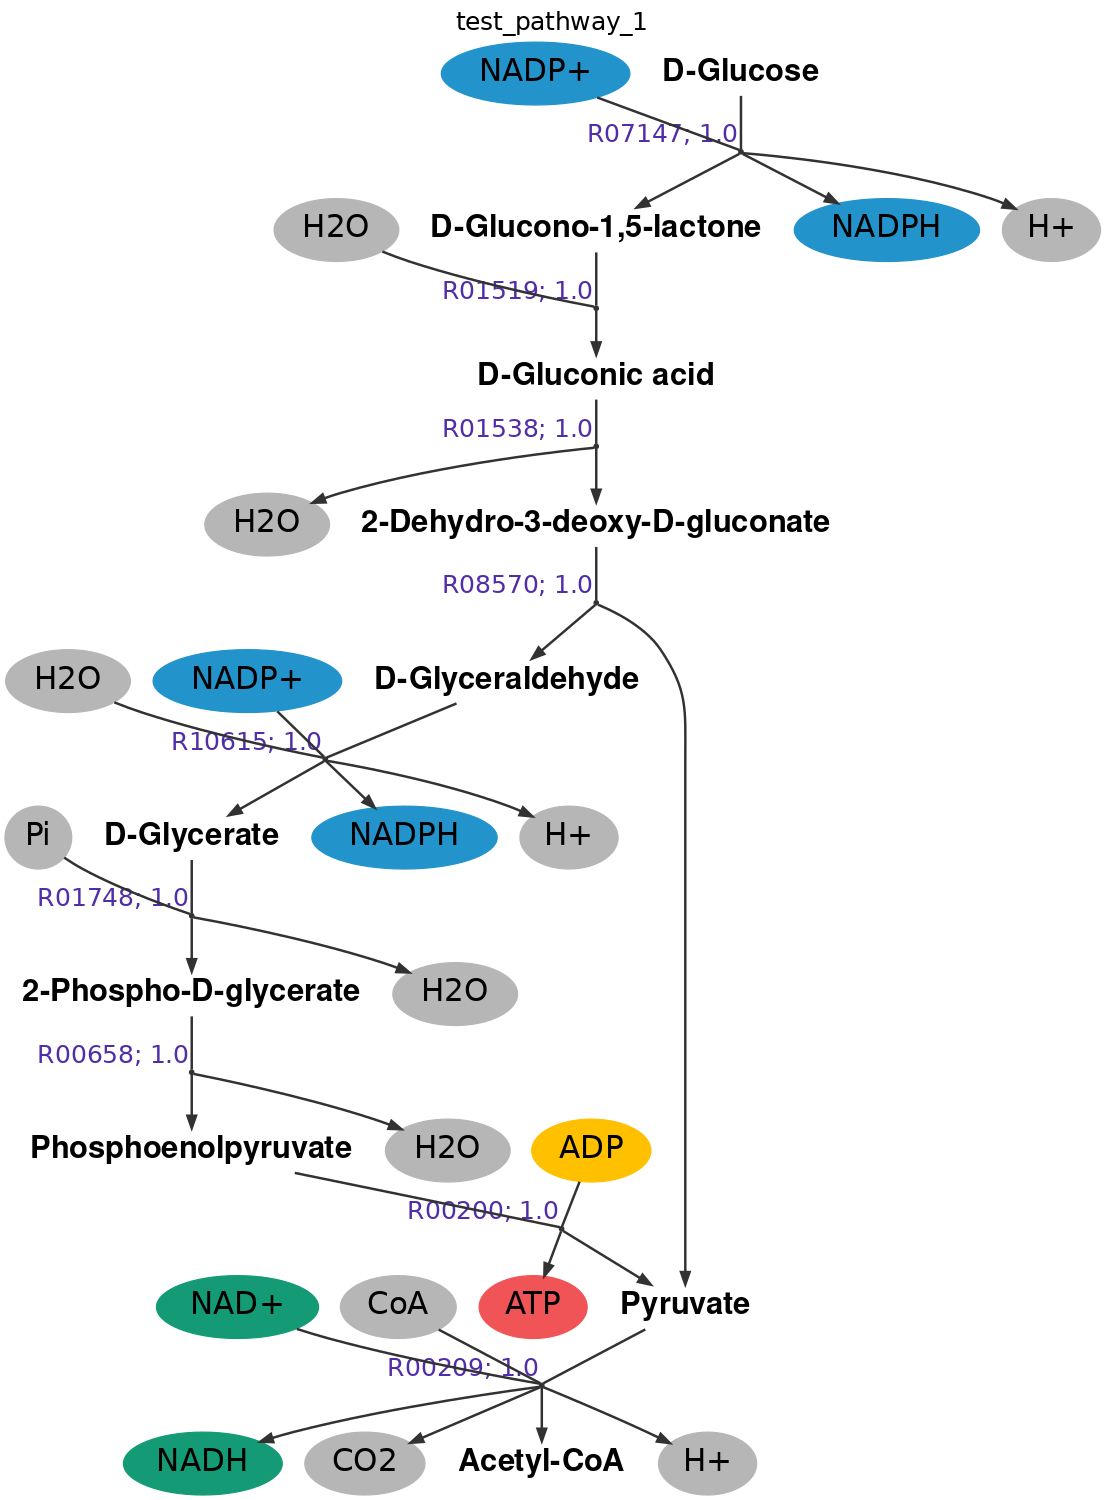

In [4]:
test_paths = pd.read_json(r'./result/temp_pathways.json')

test_path1 = Pathway(name='test_pathway_1',
                    reaction_ids=list(test_paths[1]['pathway'].keys()),
                    fluxes=list(test_paths[1]['pathway'].values()))

# Create a png image
figure_filename = 'test_pathway_1'
figure_ext = "png"

g = draw_pathway(
    test_path1, 
    imageFileName=figure_filename, 
    imageFormat=figure_ext, 
    graphTitle=test_path1.name,
    cleanup=True, 
    darkBackgroundMode=False,
    width=5,
    height=5)

Image(figure_filename + "." + figure_ext)

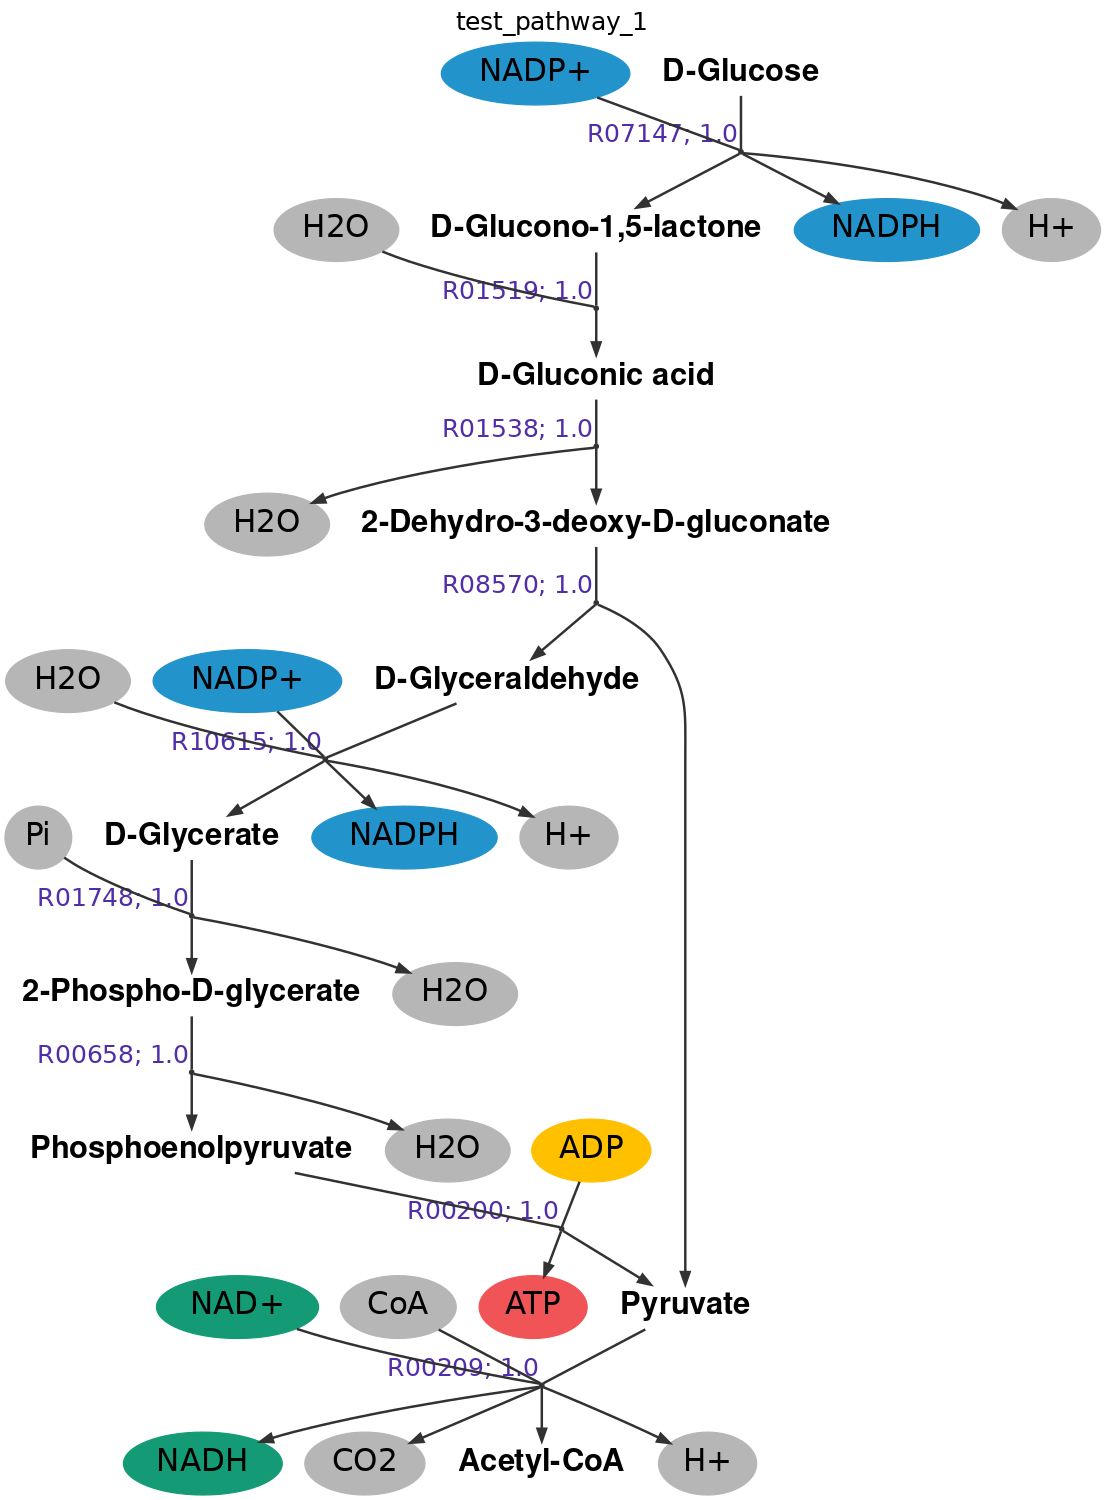

In [5]:
test_path2 = Pathway(name='test_pathway_2',
                    reaction_ids=list(test_paths[2]['pathway'].keys()),
                    fluxes=list(test_paths[2]['pathway'].values()))

# Create a png image
figure_filename2 = 'test_pathway_2'
figure_ext2 = "png"

g = draw_pathway(
    test_path2, 
    imageFileName=figure_filename2, 
    imageFormat=figure_ext2, 
    graphTitle=test_path2.name,
    cleanup=True, 
    darkBackgroundMode=False,
    width=5,
    height=5)

Image(figure_filename + "." + figure_ext)

# optStoic (e coli core)

Ejemplo con la base de datos del e coli core (BiGG) adaptada al formato de `optStoic`, incluye la glicólisis, el ciclo de Krebbs, la producción de lactato, acetaldehído, entre otros.

la forma de cargar los datos desde el notebook es la misma, pero fue necesario armar un par de funciones específicas para esta db, están importadas con el sufijo `_ecolicore`

### Settings conservados

In [6]:
pulp_solver = load_pulp_solver(
        solver_names=[
            'SCIP_CMD',
            'GUROBI',
            'GUROBI_CMD',
            'CPLEX_CMD',
            'GLPK_CMD'])

## Casos de estudio

### Caso 1: Glucosa 6-Pi -> Fructosa 6 Pi

una reacción, sin ATP ni transportadores de electrones

In [7]:
C1_user_defined_export_rxns_Sji={
            'EX_g6p':{'C00092' : -1.0},
            'EX_f6p': {'C00085': -1.0}
        }

C1_specific_bounds = {'EX_f6p': {'LB': 1, 'UB': 1},
                   'EX_g6p': {'LB':-1, 'UB': -1}}
                       
    
db_C1 =load_db_v3_ecolicore(C1_user_defined_export_rxns_Sji)

#### MinFlux

In [8]:
C1_minflux_test = optstoic.OptStoic(database=db_C1,
                    objective='MinFlux',
                    specific_bounds=C1_specific_bounds,
                    custom_flux_constraints=None,
                    add_loopless_constraints=True,
                    max_iteration=2,
                    pulp_solver=pulp_solver,
                    result_filepath='./result_C1/',
                    M=1000)

C1_minflux_lp_problem, C1_minflux_pathways = C1_minflux_test.solve(
                                max_iteration=C1_minflux_test.max_iteration)

#### EnzymeLoad

In [9]:
C1_enzymeload_test = optstoic.OptStoic(database=db_C1,
                    objective='EnzymeLoad',
                    specific_bounds=C1_specific_bounds,
                    custom_flux_constraints=None,
                    add_loopless_constraints=True,
                    max_iteration=2,
                    pulp_solver=pulp_solver,
                    result_filepath='./result_C1/',
                    M=1000)

C1_enzymeload_lp_problem, C1_enzymeload_pathways = C1_enzymeload_test.solve(
                                max_iteration=C1_enzymeload_test.max_iteration)

#### Gráfico última ruta guardada

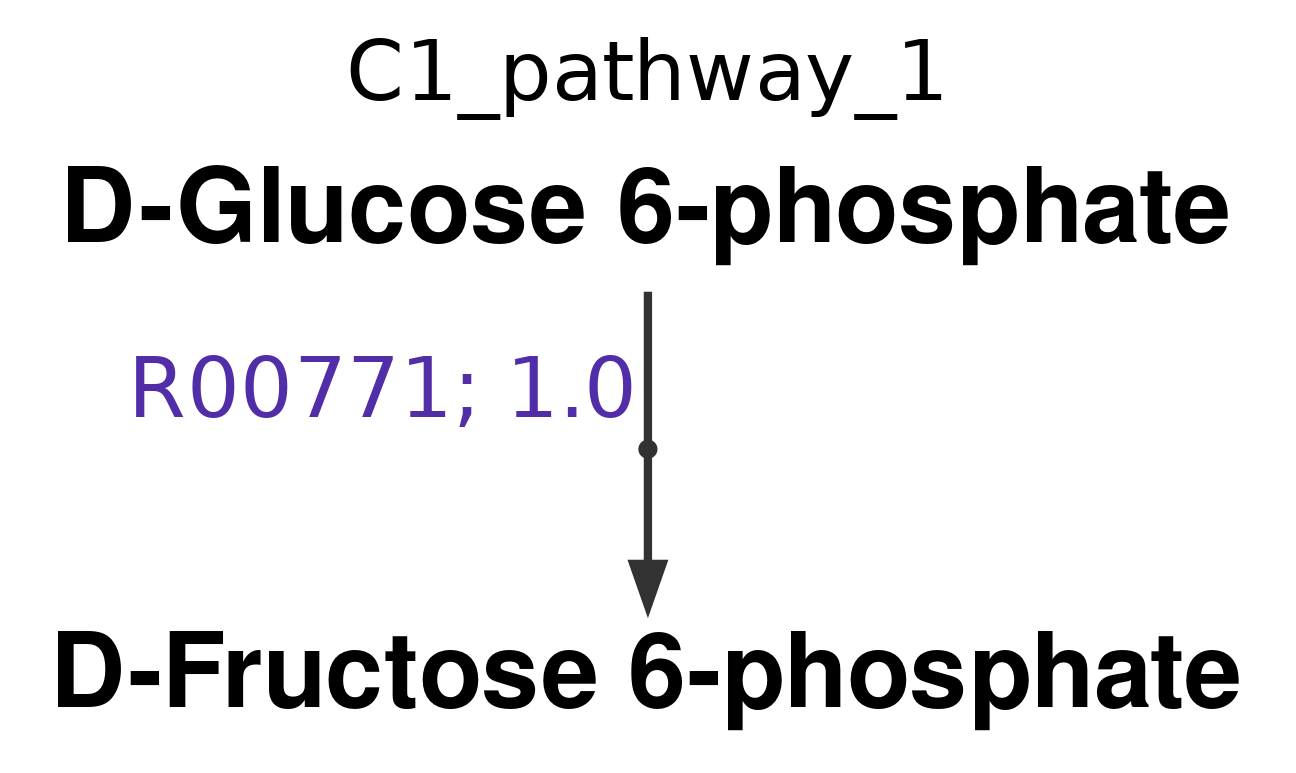

In [10]:
C1_paths = pd.read_json(r'./result_C1/temp_pathways.json')

C1_path1 = Pathway(name='C1_pathway_1',
                    reaction_ids=list(C1_paths[1]['pathway'].keys()),
                    fluxes=list(C1_paths[1]['pathway'].values()))

# Create a png image
C1_figure_filename = 'C1_pathway_1'
C1_figure_ext = "png"

g = draw_pathway(
    C1_path1, 
    imageFileName=C1_figure_filename, 
    imageFormat=C1_figure_ext, 
    graphTitle=C1_path1.name,
    cleanup=True, 
    darkBackgroundMode=False,
    width=5,
    height=5)

Image(C1_figure_filename + "." + C1_figure_ext)

### Caso 2: 3 fosfo glicerato -> fosfoenol piruvato + agua 

2 reacciones,sin ATP ni transportadores de electrones

minflux funciona solo si los `specific_bound` van en sentido contrario (A <- B <- C)

enzymeLoad funciona en ambos sentidos

In [11]:
C2_user_defined_export_rxns_Sji={
            'EX_3pg':{'C00197' : -1.0},
            'EX_pep': {'C00074': -1.0},
            'EX_h2o': {'C00001': -1.0}
        }

C2_specific_bounds = {'EX_3pg': {'LB': -1, 'UB': -1},
                   'EX_pep': {'LB':1, 'UB': 1},
                   'EX_h2o': {'LB':1, 'UB': 1}
                  }

db_C2 =load_db_v3_ecolicore(C2_user_defined_export_rxns_Sji)

#### MinFlux

In [12]:
C2_minflux_test = optstoic.OptStoic(database=db_C2,
                    objective='MinFlux',
                    specific_bounds=C2_specific_bounds,
                    custom_flux_constraints=None,
                    add_loopless_constraints=True,
                    max_iteration=2,
                    pulp_solver=pulp_solver,
                    result_filepath='./result_C2/',
                    M=1000)

C2_minflux_lp_problem, C2_minflux_pathways = C2_minflux_test.solve(
                                max_iteration=C2_minflux_test.max_iteration)

#### EnzymeLoad

In [14]:
C2_enzymeload_test = optstoic.OptStoic(database=db_C2,
                    objective='EnzymeLoad',
                    specific_bounds=C2_specific_bounds,
                    custom_flux_constraints=None,
                    add_loopless_constraints=True,
                    max_iteration=2,
                    pulp_solver=pulp_solver,
                    result_filepath='./result_C2/',
                    M=1000)

C2_enzymeload_lp_problem, C2_enzymeload_pathways = C2_enzymeload_test.solve(
                                max_iteration=C2_enzymeload_test.max_iteration)

#### Gráfico última ruta guardada

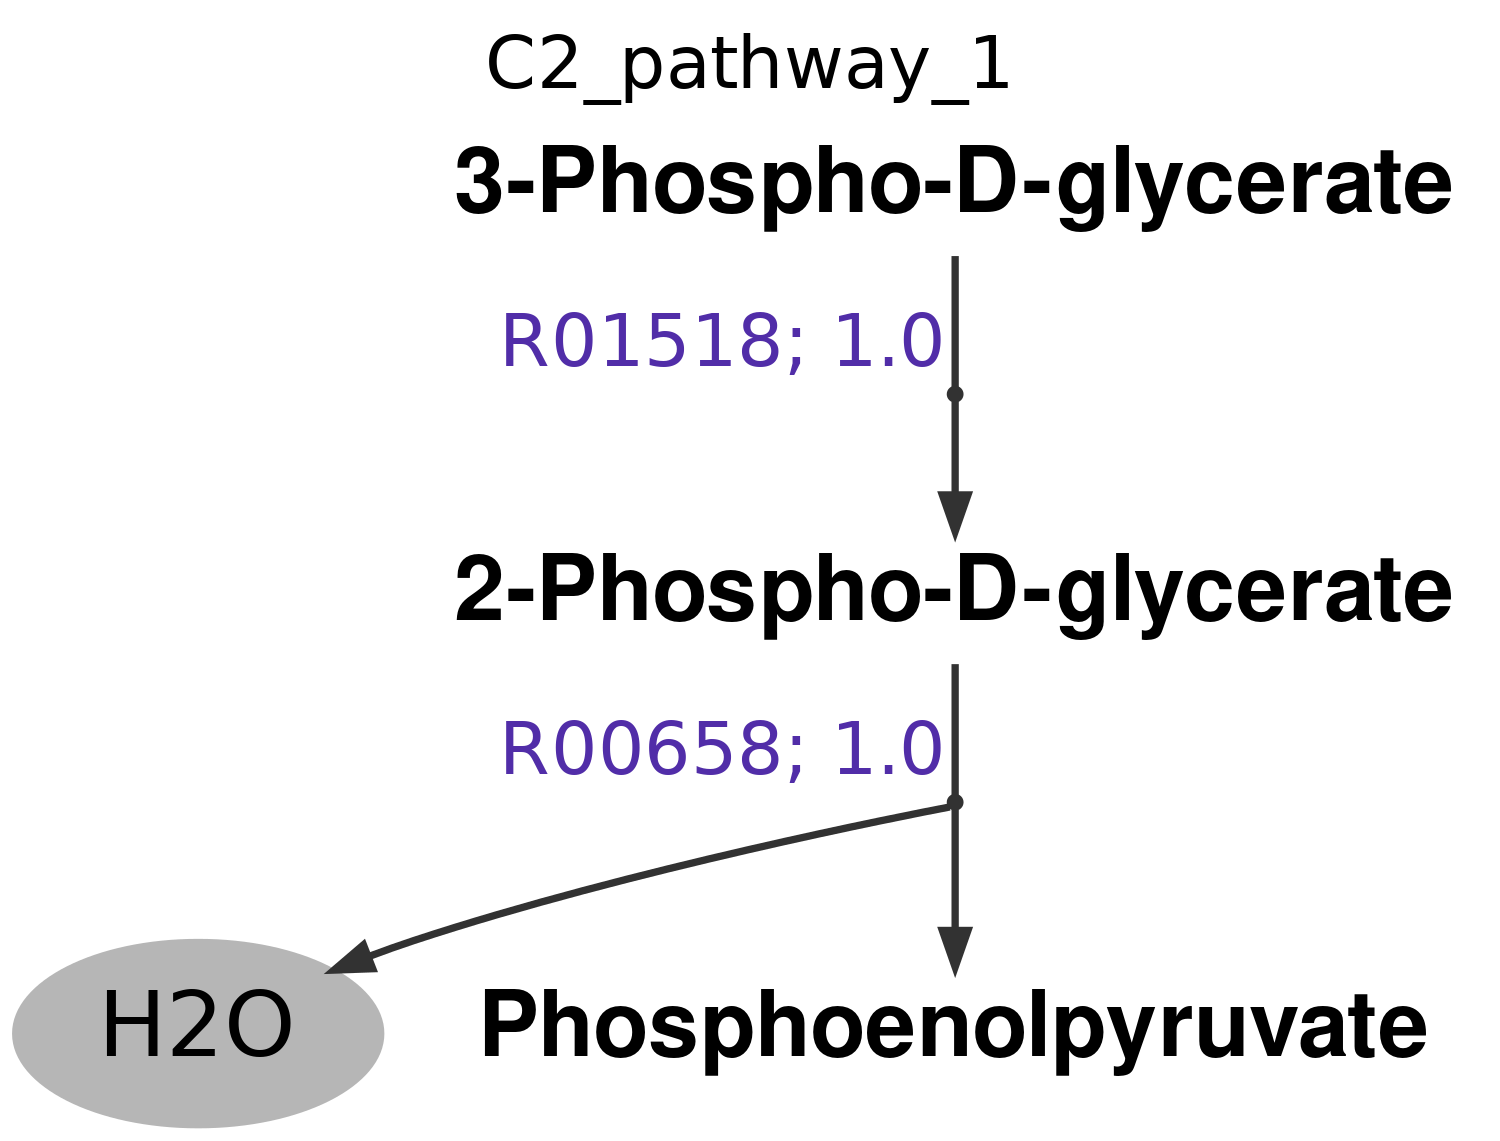

In [15]:
C2_paths = pd.read_json(r'./result_C2/temp_pathways.json')

C2_path1 = Pathway(name='C2_pathway_1',
                    reaction_ids=list(C2_paths[1]['pathway'].keys()),
                    fluxes=list(C2_paths[1]['pathway'].values()))

# Create a png image
C2_figure_filename = 'C2_pathway_1'
C2_figure_ext = "png"

g = draw_pathway(
    C2_path1, 
    imageFileName=C2_figure_filename, 
    imageFormat=C2_figure_ext, 
    graphTitle=C2_path1.name,
    cleanup=True, 
    darkBackgroundMode=False,
    width=5,
    height=5)

Image(C2_figure_filename + "." + C2_figure_ext)

### Caso 3: Acetil CoA + NADH + H+ -> NAD+ + CoA + Acetaldehído 

una reacción, sin ATP, con NAD/NADH

In [18]:
C3_user_defined_export_rxns_Sji={
            'EX_accoa':{'C00024' : -1.0},
            'EX_nadh': {'C00004': -1.0},
            'EX_hplus': {'C00080': -1.0},
            'EX_coa': {'C00010': -1.0},
            'EX_nad': {'C00003': -1.0},
            'EX_acald': {'C00084': -1.0}
        }

C3_specific_bounds = {'EX_accoa': {'LB': -1, 'UB': -1},
                   'EX_nadh': {'LB':-1, 'UB': -1},
                   'EX_hplus': {'LB':-1, 'UB': -1},
                   'EX_coa': {'LB': 1, 'UB': 1},
                   'EX_nad': {'LB':1, 'UB': 1},
                   'EX_acald': {'LB':1, 'UB': 1},
                  }

db_C3 =load_db_v3_ecolicore(C3_user_defined_export_rxns_Sji)

#### MinFlux

In [19]:
C3_minflux_test = optstoic.OptStoic(database=db_C3,
                    objective='MinFlux',
                    specific_bounds=C3_specific_bounds,
                    custom_flux_constraints=None,
                    add_loopless_constraints=True,
                    max_iteration=2,
                    pulp_solver=pulp_solver,
                    result_filepath='./result_C3/',
                    M=1000)

C3_minflux_lp_problem, C3_minflux_pathways = C3_minflux_test.solve(
                                max_iteration=C3_minflux_test.max_iteration)

#### EnzymeLoad

In [20]:
C3_enzymeload_test = optstoic.OptStoic(database=db_C3,
                    objective='EnzymeLoad',
                    specific_bounds=C3_specific_bounds,
                    custom_flux_constraints=None,
                    add_loopless_constraints=True,
                    max_iteration=2,
                    pulp_solver=pulp_solver,
                    result_filepath='./result_C3/',
                    M=1000)

C3_enzymeload_lp_problem, C3_enzymeload_pathways = C3_enzymeload_test.solve(
                                max_iteration=C3_enzymeload_test.max_iteration)

#### Gráfico última ruta guardada

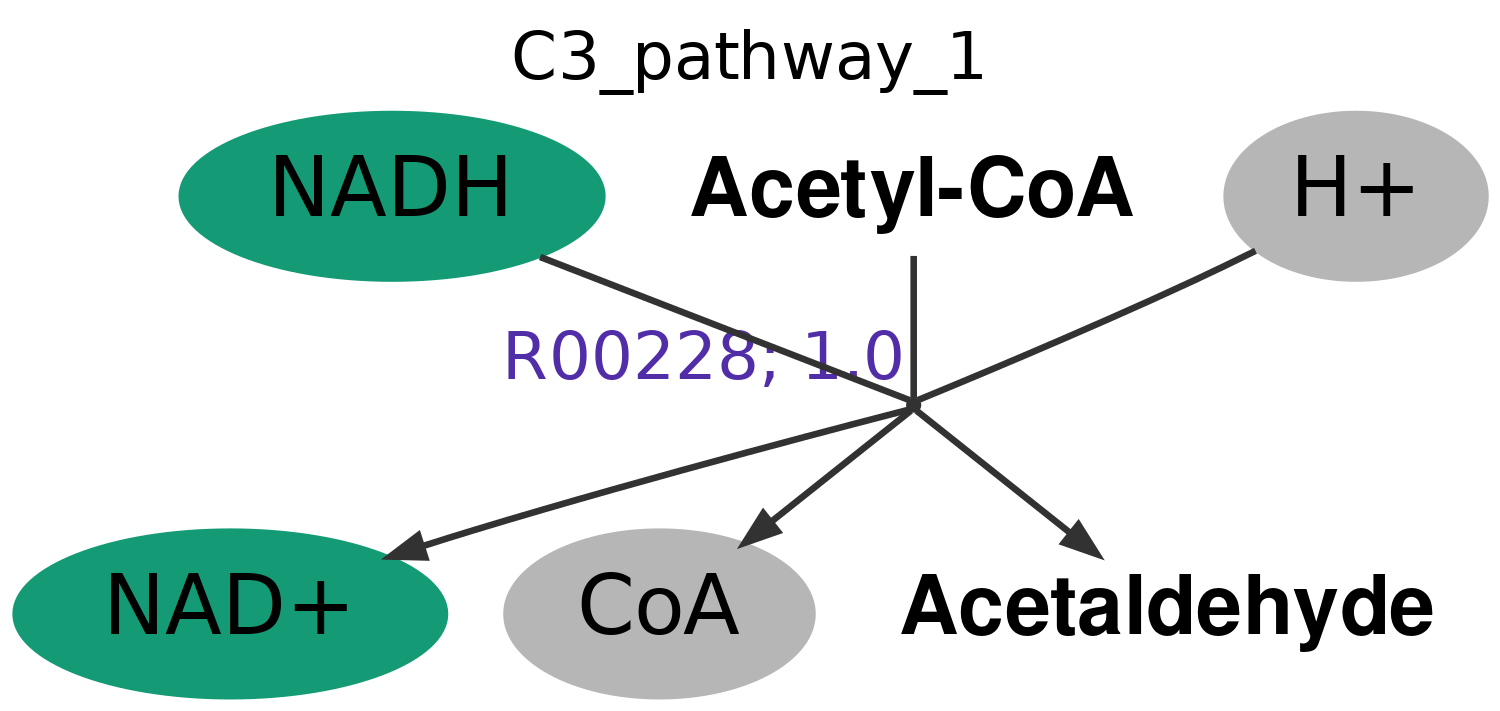

In [21]:
C3_paths = pd.read_json(r'./result_C3/temp_pathways.json')

C3_path1 = Pathway(name='C3_pathway_1',
                    reaction_ids=list(C3_paths[1]['pathway'].keys()),
                    fluxes=list(C3_paths[1]['pathway'].values()))

# Create a png image
C3_figure_filename = 'C3_pathway_1'
C3_figure_ext = "png"

g = draw_pathway(
    C3_path1, 
    imageFileName=C3_figure_filename, 
    imageFormat=C3_figure_ext, 
    graphTitle=C3_path1.name,
    cleanup=True, 
    darkBackgroundMode=False,
    width=5,
    height=5)

Image(C3_figure_filename + "." + C3_figure_ext)

### Caso 4: succinato + CoA + ATP -> succinil-CoA + ADP + Pi

una reacción, con consumo de ATP

este caso si funciona porque en la definición de esta reacción en la db aparecen todos los compuestos, pero en algunas reacciones que tienen consumo de ATP aparecen solo los grupos fosfatos 

In [22]:
C4_user_defined_export_rxns_Sji={
            'EX_atp': {'C00002': -1.0},
            'EX_coa': {'C00010': -1.0},
            'EX_succinate': {'C00042': -1.0},
            'EX_adp': {'C00008': -1.0},
            'EX_phosphate': {'C00009': -1.0},
            'EX_succinil-coa': {'C00091': -1.0}
            }

C4_specific_bounds = {'EX_atp': {'LB': -1, 'UB': -1},
                   'EX_coa': {'LB':-1, 'UB': -1},
                   'EX_succinate': {'LB': -1, 'UB': -1},
                   'EX_adp': {'LB':1, 'UB': 1},
                   'EX_phosphate': {'LB':1, 'UB': 1},
                   'EX_succinil-coa':{'LB':1, 'UB': 1}
                  }

db_C4 =load_db_v3_ecolicore(C4_user_defined_export_rxns_Sji)

#### MinFlux

In [23]:
C4_minflux_test = optstoic.OptStoic(database=db_C4,
                    objective='MinFlux',
                    specific_bounds=C4_specific_bounds,
                    custom_flux_constraints=None,
                    add_loopless_constraints=True,
                    max_iteration=2,
                    pulp_solver=pulp_solver,
                    result_filepath='./result_C4/',
                    M=1000)

C4_minflux_lp_problem, C4_minflux_pathways = C4_minflux_test.solve(
                                max_iteration=C4_minflux_test.max_iteration)

#### EnzymeLoad

In [24]:
C4_enzymeload_test = optstoic.OptStoic(database=db_C4,
                    objective='EnzymeLoad',
                    specific_bounds=C4_specific_bounds,
                    custom_flux_constraints=None,
                    add_loopless_constraints=True,
                    max_iteration=2,
                    pulp_solver=pulp_solver,
                    result_filepath='./result_C4/',
                    M=1000)

C4_enzymeload_lp_problem, C4_enzymeload_pathways = C4_enzymeload_test.solve(
                                max_iteration=C4_enzymeload_test.max_iteration)

#### Gráfico última ruta guardada

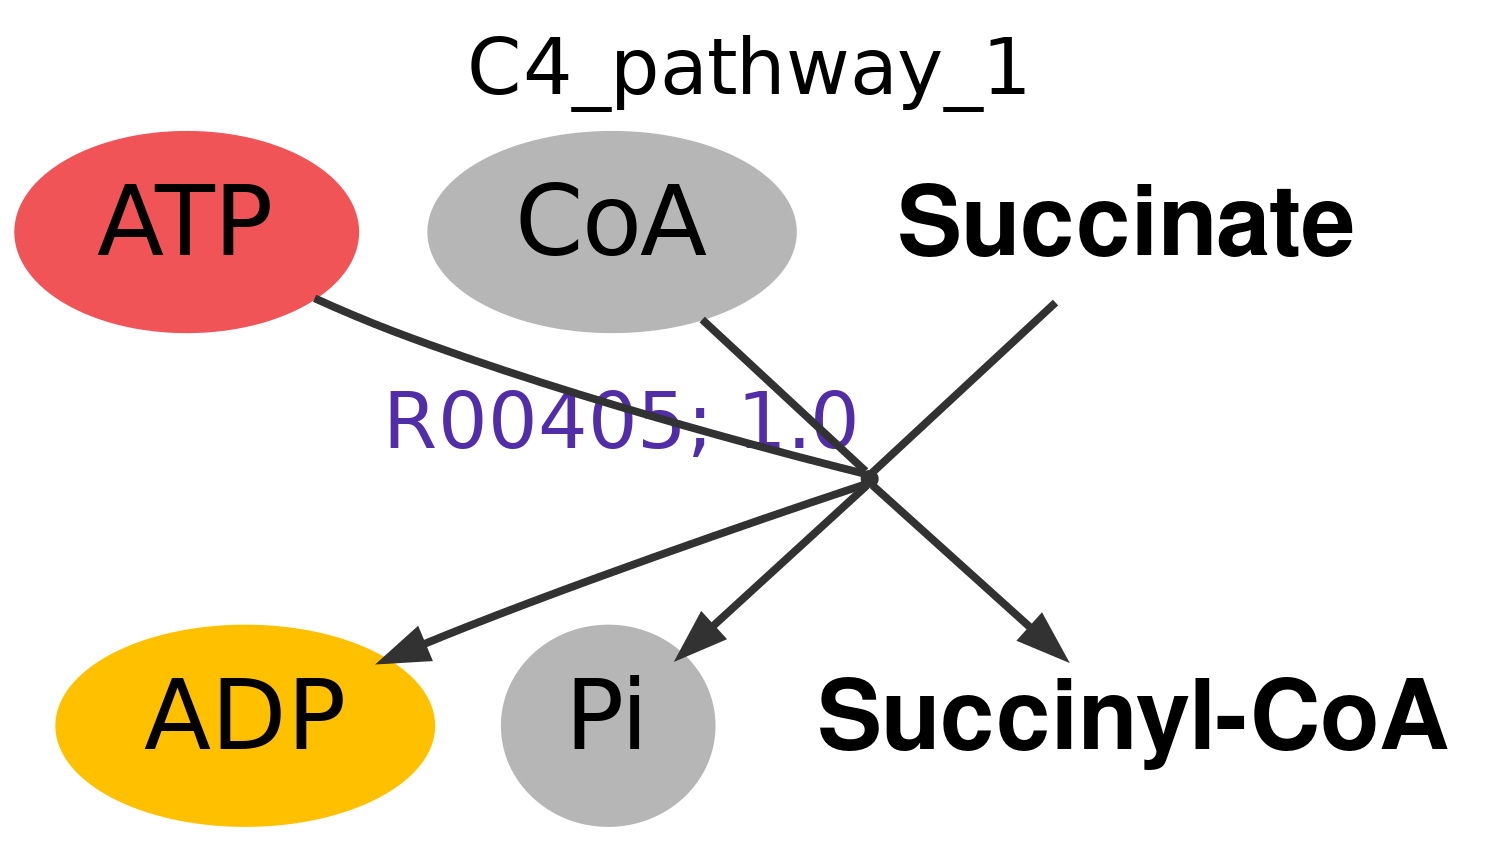

In [25]:
C4_paths = pd.read_json(r'./result_C4/temp_pathways.json')

C4_path1 = Pathway(name='C4_pathway_1',
                    reaction_ids=list(C4_paths[1]['pathway'].keys()),
                    fluxes=list(C4_paths[1]['pathway'].values()))

# Create a png image
C4_figure_filename = 'C4_pathway_1'
C4_figure_ext = "png"

g = draw_pathway(
    C4_path1, 
    imageFileName=C4_figure_filename, 
    imageFormat=C4_figure_ext, 
    graphTitle=C4_path1.name,
    cleanup=True, 
    darkBackgroundMode=False,
    width=5,
    height=5)

Image(C4_figure_filename + "." + C4_figure_ext)